# Simple Synthetic Inversions

## Import packages

In [6]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import RIS_gravity_inversion.plotting as inv_plotting

import logging

import numpy as np
import pandas as pd
import verde as vd
import xarray as xr
from polartoolkit import maps
from polartoolkit import utils as polar_utils

from invert4geom import inversion, plotting, synthetic, utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create observed gravity data
To run the inversion, we need to have observed gravity data. In this simple example, we will first create a synthetic topography, which represents the `true` Earth topography which we hope to recover during the inverison. From this topography, we will create a layer of vertical right-rectangular prisms, which allows us to calculated the gravity effect of the topography. This will act as our observed gravity data. 

### True topography

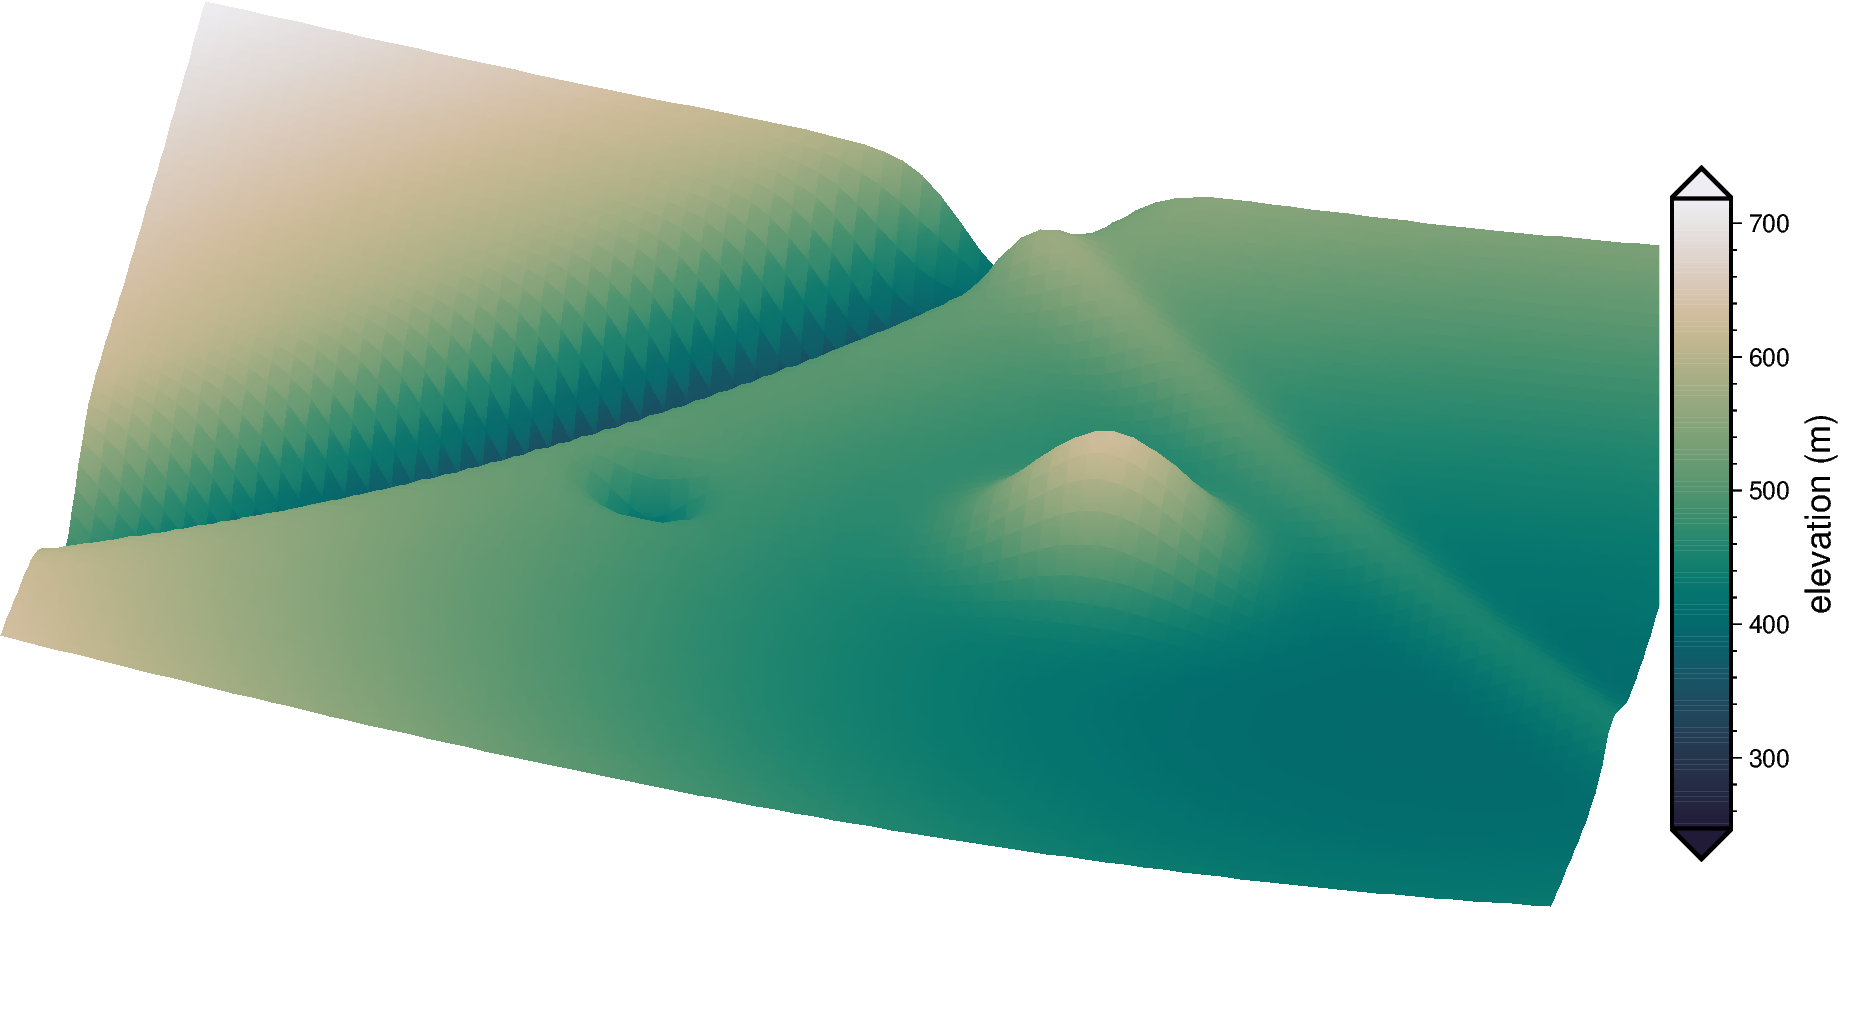

<xarray.DataArray 'upward' (northing: 61, easting: 81)> Size: 40kB
array([[637.12943453, 632.19538446, 627.28784729, ..., 429.33158321,
        429.94283295, 430.64751872],
       [634.98693024, 630.03468543, 625.10864111, ..., 426.39921792,
        427.01279345, 427.72016051],
       [632.95724141, 627.98926162, 623.04617819, ..., 423.6241977 ,
        424.23997422, 424.94987872],
       ...,
       [709.90739328, 705.61112993, 701.33808009, ..., 528.97704204,
        529.50925875, 530.12283044],
       [714.19597392, 709.93730524, 705.70164695, ..., 534.84886306,
        535.37642258, 535.98462518],
       [718.55151946, 714.33103249, 710.13334959, ..., 540.8123708 ,
        541.33520041, 541.93795008]])
Coordinates:
  * easting   (easting) float64 648B 0.0 500.0 1e+03 ... 3.9e+04 3.95e+04 4e+04
  * northing  (northing) float64 488B 0.0 500.0 1e+03 ... 2.9e+04 2.95e+04 3e+04

In [2]:
# set grid parameters
spacing = 500
region = [0, 40000, 0, 30000]

# create synthetic topography data
true_topography = synthetic.synthetic_topography_simple(
    spacing,
    region,
)

# plot the true topography
fig = maps.plot_3d(
    true_topography,
    fig_height=10,
    exaggeration=3,
    title="True topography",
    cmaps="rain",
    reverse_cpt=True,
    grd2_cpt=True,
    cbar_labels="elevation (m)",
    cbar_perspective=False,
    frame=["nSWe", "xaf10000", "yaf10000"],
    # zshifts=[10],
    # cbar_yshift=[0, 4],
)

fig.show()

true_topography

### Prism layer

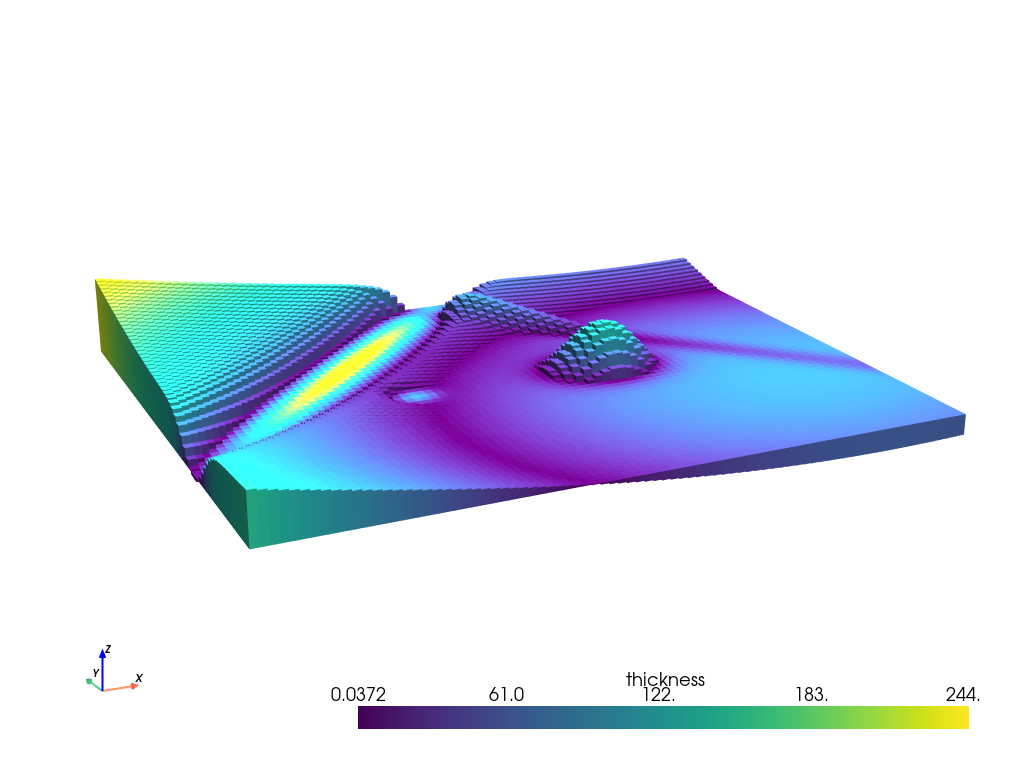

mean topography is 490.93632804524606 m


In [3]:
# the density contrast is between rock (~2670 kg/m3) and air (~1 kg/m3)
density_contrast = 2670 - 1

# prisms are created between the mean topography value and the height of the topography
zref = true_topography.values.mean()

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density = xr.where(true_topography >= zref, density_contrast, -density_contrast)

# create layer of prisms
prisms = utils.grids_to_prisms(
    true_topography,
    zref,
    density=density,
)

plotting.show_prism_layers(
    prisms,
    color_by="thickness",
    log_scale=False,
    zscale=20,
    backend="static",
)

print(f"mean topography is {zref} m")

### Forward gravity of prism layer

In [13]:
# make pandas dataframe of locations to calculate gravity
# this represents the station locations of a gravity survey
# create lists of coordinates
coords = vd.grid_coordinates(
    region=region,
    spacing=spacing,
    pixel_register=False,
    extra_coords=1000,  # survey elevation
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
).upward

grav_df = vd.grid_to_table(observations)

grav_df["observed_grav"] = prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

grav_df

  0%|          | 0/4941 [00:00<?, ?it/s]

,northing,easting,upward,observed_grav
0,0.0,0.0,1000.0,6.973239
1,0.0,500.0,1000.0,8.543041
2,0.0,1000.0,1000.0,8.808350
3,0.0,1500.0,1000.0,8.728426
4,0.0,2000.0,1000.0,8.524345
...,...,...,...,...
4936,30000.0,38000.0,1000.0,2.835035
4937,30000.0,38500.0,1000.0,2.818610
4938,30000.0,39000.0,1000.0,2.767819
4939,30000.0,39500.0,1000.0,2.610552


## Constraint Points

In [14]:
# create 10 random point within the region
num_constraints = 10
coords = vd.scatter_points(region=region, size=num_constraints, random_state=7)
constraints = pd.DataFrame(data={"easting": coords[0], "northing": coords[1]})

# sample true topography at these points
constraints = utils.sample_grids(
    constraints, true_topography, "upward", coord_names=("easting", "northing")
)
constraints

,easting,northing,upward
0,3052.331575,20376.899884,619.774197
1,31196.751690,24112.171083,479.563796
2,17536.369258,11428.233994,465.789125
3,28938.607113,1978.090407,426.413559
4,39119.580480,8644.367979,428.589749
5,21539.834816,27287.805832,549.574359
6,20044.818546,6401.560607,450.406655
7,2882.045334,13563.718855,461.388181
8,10737.559204,27936.180591,614.078942
9,19995.300033,746.976827,470.388396


## Uncertainty Analysis

In [10]:
plot = True
# plot = False
runs = 3

In [16]:
# 2% of max absolute value
maxabs = np.max(np.abs(grav_df.observed_grav)) * 0.02
print(f"Max absolute value of gravity: {maxabs} mGal")
grav_df["uncert"] = maxabs
grav_df

Max absolute value of gravity: 0.38608995149905384 mGal


,northing,easting,upward,observed_grav,uncert
0,0.0,0.0,1000.0,6.973239,0.38609
1,0.0,500.0,1000.0,8.543041,0.38609
2,0.0,1000.0,1000.0,8.808350,0.38609
3,0.0,1500.0,1000.0,8.728426,0.38609
4,0.0,2000.0,1000.0,8.524345,0.38609
...,...,...,...,...,...
4936,30000.0,38000.0,1000.0,2.835035,0.38609
4937,30000.0,38500.0,1000.0,2.818610,0.38609
4938,30000.0,39000.0,1000.0,2.767819,0.38609
4939,30000.0,39500.0,1000.0,2.610552,0.38609


In [17]:
# calculate uncertainty as 2% of each points depth
_, constraints["uncert"] = synthetic.contaminate(
    constraints.upward,
    stddev=0.02,
    percent=True,
    percent_as_max_abs=False,
    seed=0,
)

print(
    f"mean constraint uncertainty: {np.nanmean(constraints.uncert)} m"
)
constraints

mean constraint uncertainty: 9.931933919019471 m


,easting,northing,upward,uncert
0,3052.331575,20376.899884,619.774197,12.395484
1,31196.751690,24112.171083,479.563796,9.591276
2,17536.369258,11428.233994,465.789125,9.315783
3,28938.607113,1978.090407,426.413559,8.528271
4,39119.580480,8644.367979,428.589749,8.571795
5,21539.834816,27287.805832,549.574359,10.991487
6,20044.818546,6401.560607,450.406655,9.008133
7,2882.045334,13563.718855,461.388181,9.227764
8,10737.559204,27936.180591,614.078942,12.281579
9,19995.300033,746.976827,470.388396,9.407768


In [ ]:
kwargs = dict(
    grav_spacing=spacing,
    inversion_region=region,
    layer_spacing=spacing,
)

inversion_args = dict(
    input_grav_column="observed_grav",
    apply_weights=False,
    weights_after_solving=True,
    max_iterations=50,
    l2_norm_tolerance=0.15,
    delta_l2_norm_tolerance=1.02,
    deriv_type="annulus",
    solver_type="scipy least squares",
)

starting_args = dict(
    density_contrast=1276,  # 2300 - 1024
    regional_tension_factor=0.5,
    regional_damping=1.3894954943731388e-08,
    regional_grid_method="verde",
    starting_bed_tension=0.5,
    starting_bed_damping=10**-20,
    starting_bed_method="spline",
)

In [ ]:
path = "../../synthetic_data/monte_carlo_results/"
prefix = "simple_monte_carlo_full"
fname = path + prefix

full_surface_results = uncert.monte_carlo_inversion_uncertainty_loop(
    fname=fname,
    runs=runs,
    grav=grav_df,
    constraints=constrains,
    sample_grav=True,  # will recalculate regional field
    sample_constraints=True,  # will recalculate starting bed, bed gravity, and regional field
    sample_density_contrast=True,  # will recalculate bed gravity and regional field
    run_damping_CV=True,
    damping_CV_fname=path + "damping_CV_results/" + prefix,
    inversion_args=inversion_args,
    starting_args=starting_args,
    sampling="LHC",
    **kwargs,
)

params, values, grav_dfs, prism_dfs = full_surface_results

# ds = uncert.merged_stats(
#     full_surface_results,
#     "topo",
#     "starting_bed",
#     plot=plot,
#     mask="../../plotting/RIS_outline.shp",
#     title="Full Monte Carlo simulation",
#     constraints=constraints,
#     weight_by="constraints",
# )
ds = uncert.merged_stats(
    full_surface_results,
    "topo",
    -1,
    plot=plot,
    # plot=False,
    mask="../../data/Ross_Sea_outline.shp",
    title="Full Monte Carlo simulation",
    constraints=constraints,
    weight_by="constraints",
)